# Library Import

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW, RMSprop
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

# Data Load

In [3]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cp -r /content/drive/MyDrive/DATASET .

# Data Preprocessing

In [5]:
train_dir = "/content/DATASET/TRAIN/"
test_dir = "/content/DATASET/TEST/"

In [6]:
img_width = 224
img_height = 224
batch_size = 32
model_dir = "./model"
checkpoint = "model_checkpoint_best_.keras"
checkpoint_path = os.path.join(model_dir, checkpoint)

In [7]:
os.makedirs(model_dir, exist_ok=True)

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle="True"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 1424 images belonging to 26 classes.
Found 351 images belonging to 26 classes.
Found 208 images belonging to 26 classes.


In [9]:
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

In [10]:
class_weights = dict(enumerate(class_weights))

In [11]:
print(train_generator.class_indices)
print(train_generator.samples)

{'Aceh_Pintu_Aceh': 0, 'Bali_Barong': 1, 'Bali_Merak': 2, 'DKI_Ondel_Ondel': 3, 'Jawa_Barat_Megamendung': 4, 'Jawa_Tengah_Batik_Lasem': 5, 'Jawa_Timur_Pring': 6, 'Kalimantan_Barat_Insang': 7, 'Kalimantan_Dayak': 8, 'Lampung_Gajah': 9, 'Madura_Mataketeran': 10, 'Maluku_Pala': 11, 'NTB_Lumbung': 12, 'Palembang_Songket': 13, 'Papua_Asmat': 14, 'Papua_Cendrawasih': 15, 'Papua_Tifa': 16, 'Solo_Parang': 17, 'Solo_Sidoluhur': 18, 'Solo_Sogan': 19, 'Solo_Truntum': 20, 'Sulawesi_Selatan_Lontara': 21, 'Sumatera_Barat_Rumah_Minang': 22, 'Sumatera_Utara_Boraspati': 23, 'Yogyakarta_Kawung': 24, 'Yogyakarta_Sidomukti': 25}
1424


# Model Initialization

In [12]:
base_model = EfficientNetB0(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=l2(1e-4))
])

In [14]:
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [16]:
# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading model...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("No checkpoint found. Training model from scratch...")

No checkpoint found. Training model from scratch...


In [17]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8),
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1),
]

# Model Training

In [18]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1198 - loss: 4.0839
Epoch 1: val_accuracy improved from -inf to 0.51282, saving model to ./model/model_checkpoint_best_.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.1210 - loss: 4.0728 - val_accuracy: 0.5128 - val_loss: 2.1718 - learning_rate: 0.0010
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3433 - loss: 2.5294
Epoch 2: val_accuracy improved from 0.51282 to 0.60969, saving model to ./model/model_checkpoint_best_.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.3436 - loss: 2.5263 - val_accuracy: 0.6097 - val_loss: 1.7676 - learning_rate: 0.0010
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4434 - loss: 1.9745
Epoch 3: val_accuracy improved from 0.60969 to 0.63533, saving model to ./model/model_checkpoint_best_.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.4435 - loss: 1.9733 - val_accuracy: 0.6353 - val_loss: 1.4791 - learning_rate: 0.0010
Epoch 4

In [29]:
# Fine-tuning
fine_tune_at = 200  # Unfreeze layers from 200 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [30]:
history_fine_tune = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks,
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5842 - loss: 1.4286
Epoch 1: val_accuracy did not improve from 0.81766
45/45 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.5843 - loss: 1.4285 - val_accuracy: 0.8063 - val_loss: 0.6986 - learning_rate: 1.0000e-05
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6129 - loss: 1.3699
Epoch 2: val_accuracy did not improve from 0.81766
45/45 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.6127 - loss: 1.3702 - val_accuracy: 0.7977 - val_loss: 0.7959 - learning_rate: 1.0000e-05
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6443 - loss: 1.2646
Epoch 3: val_accuracy did not improve from 0.81766
45/45 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.6443 - loss: 1.2651 - val_accuracy: 0.7863 - val_loss: 0.7618 - learning_rate: 1.0000e-05
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6299 - loss: 1.2973
Epoch 4: val_accuracy did not improve from 0.81766
45/45 ━━━━━━━━━━━━━━━━━━━━ 168s 

# Evaluation

In [31]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.2%}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8281 - loss: 0.6731
Validation Loss: 0.707, Validation Accuracy: 80.91%
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8927 - loss: 0.4536
Test Loss: 0.429, Test Accuracy: 89.42%


In [21]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
                             precision    recall  f1-score   support

            Aceh_Pintu_Aceh       1.00      1.00      1.00         8
                Bali_Barong       1.00      0.75      0.86         8
                 Bali_Merak       1.00      0.88      0.93         8
            DKI_Ondel_Ondel       0.89      1.00      0.94         8
     Jawa_Barat_Megamendung       1.00      0.88      0.93         8
    Jawa_Tengah_Batik_Lasem       1.00      0.75      0.86         8
           Jawa_Timur_Pring       0.70      0.88      0.78         8
    Kalimantan_Barat_Insang       1.00      0.75      0.86         8
           Kalimantan_Dayak       1.00      1.00      1.00         8
              Lampung_Gajah       1.00      1.00      1.00         8
         Madura_Mataketeran       1.00      0.88      0.93         8
                Maluku_Pala       0.89      1.00      0.94         8
                NTB_Lumbung       0.89      1.00      0.94       

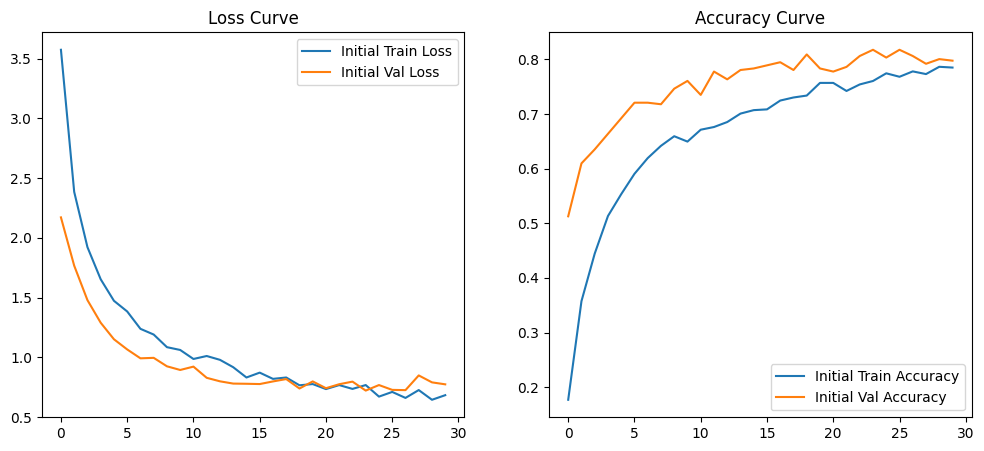

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


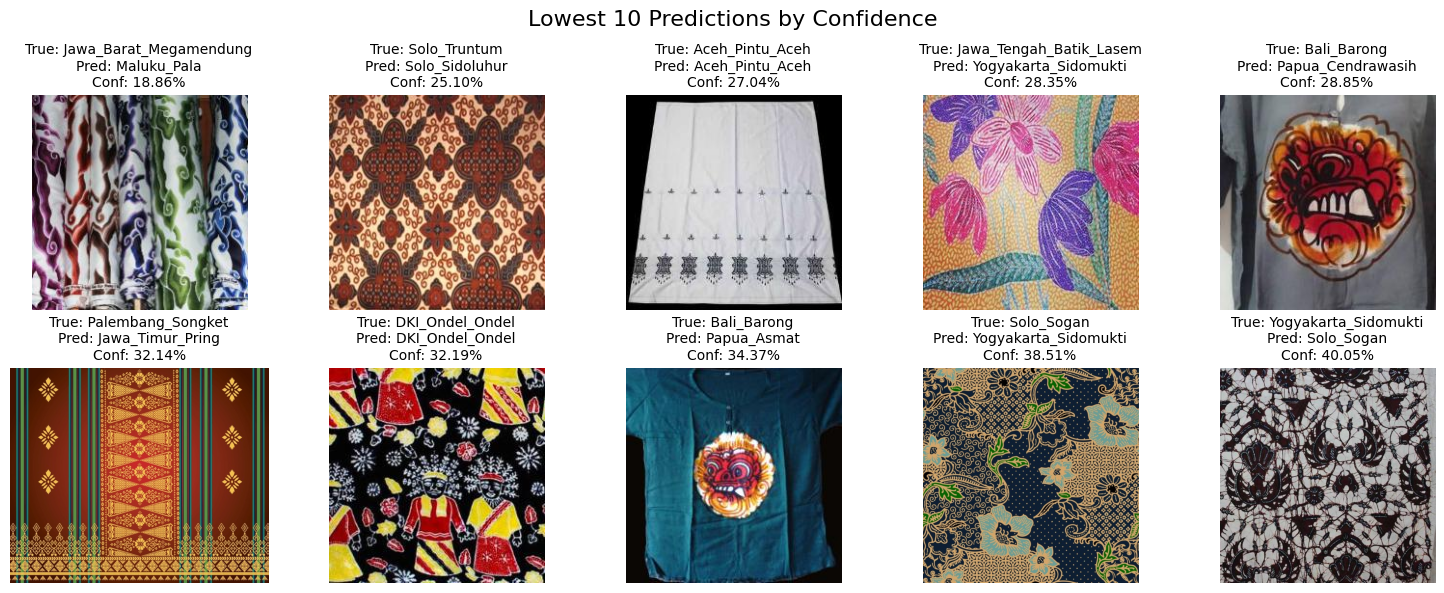

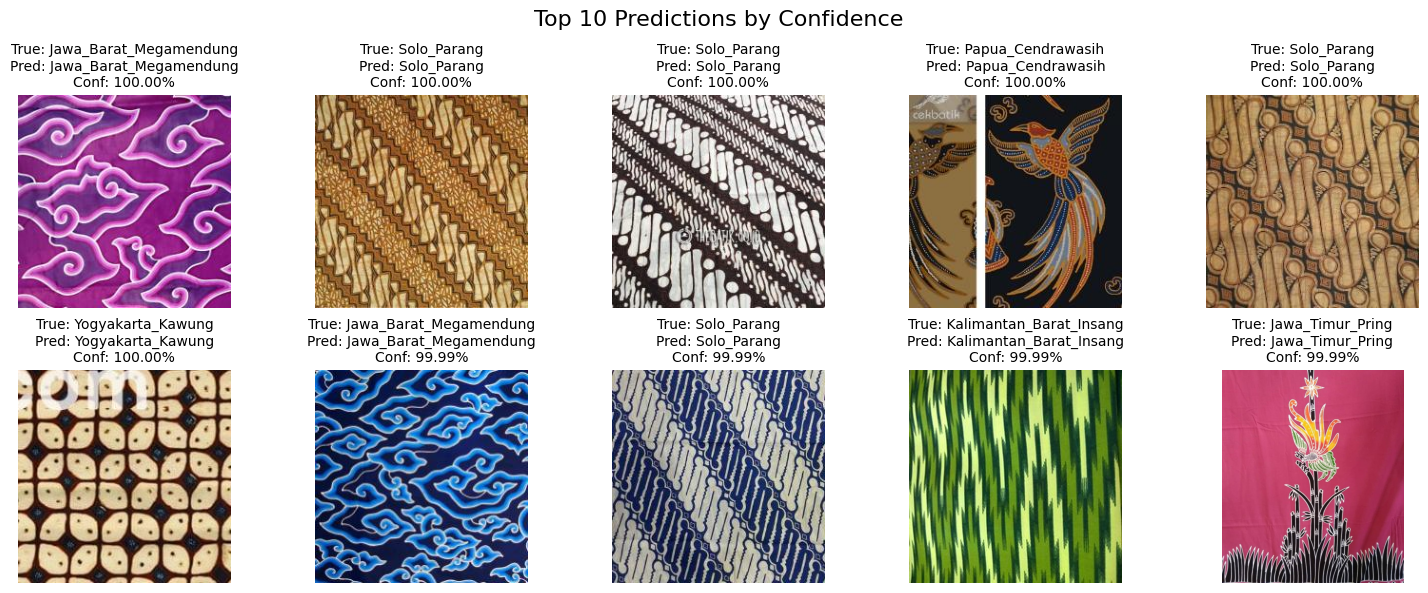

In [23]:
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")

# Save Model

In [25]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [28]:
import tensorflowjs as tfjs

os.makedirs('model_saved', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

# SavedModel
model.export('model_saved')  # or model.save('model_saved') for Keras Sequential/Functional models

# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# TFJS
tfjs_target_dir = 'tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_target_dir)

# Create ZIP file
with zipfile.ZipFile('models_bundle.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add SavedModel directory
    for root, dirs, files in os.walk('model_saved'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), '.'))

    # Add TFLite model file
    zipf.write('model.tflite')

    # Add TFJS model directory
    for root, dirs, files in os.walk(tfjs_target_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), '.'))

Saved artifact at 'model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  133073697882768: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133073697883152: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133073824485968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824485392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824486928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824483472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824489808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824484240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824491728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133073824490384: TensorSpec(shape=(), dtype=tf.resource, name=None

failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32
